In [2]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import numpy as np
%matplotlib inline
import re
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from pyhanspell.hanspell import spell_checker

C:\Users\User\anaconda3\envs\AI\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\User\anaconda3\envs\AI\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\User\anaconda3\envs\AI\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\User\anaconda3\envs\AI\lib\site-packages\tensorflow\python\framework\dtypes.

In [13]:
stock_list = os.listdir('KOSPI_largecap/Classificated')
root = 'KOSPI_largecap/Classificated'

# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','걍','과','도','를','으로','자','에','와','한','하다', '이다', '에서']

In [14]:
def Data_loader(x_stock_list, x_root):
    df = pd.read_excel(x_root + '/' + x_stock_list[0], engine='openpyxl')
    df = df[df['rating'] != 3]
    '''
    rating labeling 시 찬티도 안티도 아닌 댓글에는 3을 부여했음
    그래서 rating이 3인 댓글을은 제외
    ''' 
    # 데이터프레임 만들기
    for i in x_stock_list[1:]:
        df2 = pd.read_excel(x_root + '/' + i, engine='openpyxl')
        df2 = df2[df2['rating'] != 3]
        df = df.append(df2)
    
    # 칼럼 수정
    df['comment'] = df['title'] + ' ' +df['content'] # 댓글 제목과 내용 합침
    df = df[['rating', 'comment']]
    df = df.reset_index(drop = True)
    
    for i in df.index:
        if df.loc[i, 'rating'] == 1:
            df.loc[i, 'rating'] = 0 # 긍정 댓글 label 1에서 0으로 수정
        elif df.loc[i, 'rating'] == 2:
            df.loc[i, 'rating'] = 1 # 부정 댓글 label 2에서 1로 수정
    
    # 데이터 셔플링 후 인덱스 reset
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df


def Pre_processing(x_df, x_stopwords):
    # 중복 행 제거
    x_df.drop_duplicates(['comment'], inplace = True)
    x_df = x_df.reset_index(drop = True)
    
    # 한글 외 문자 제거
    x_df['comment'] = x_df['comment'].str.replace("[^ㄱ-ㅎ ㅏ-ㅣ 가-힣 ]", "")
    
    # 맞춤법 교정
    for i in range(len(x_df)):
        sent = str(x_df.loc[i, 'comment'])
        sent = spell_checker.check(sent).checked
        x_df.loc[i, 'comment'] = sent
    
    # rating이 0,1이 아니면 제거
    for i in range(len(x_df)):
        if not(x_df['rating'][i] == 0 or x_df['rating'][i] == 1):
            x_df = x_df.drop(i)
            
    # 토큰화
    okt = Okt()
    tokenized = []

    for i in x_df['comment']:
        temp_x = []
        temp_x = okt.morphs(i, stem = False) # 형태소 추출
        temp_x = [word for word in temp_x if not word in x_stopwords] # 불용어 제거
        tokenized.append(temp_x)
        
    # 한 음절 제거
    #new_tokenized = []
    #for i in tokenized:
        #new = [item for item in i if len(item) != 1]
        #new_tokenized.append(new)

    #tokenized = new_tokenized
    
    return x_df, tokenized

In [15]:
# 데이터셋 정의
df = Data_loader(stock_list, root)

# 전처리
df_new, tokenized = Pre_processing(df, stopwords)

# 데이터 저장
data = df_new
token = tokenized

In [30]:
#token
tokenizer = Tokenizer()
# 빈도수 기준 단어집합 생성
tokenizer.fit_on_texts(tokenized)

# 단어별 인덱스 확인
#tokenizer.word_index

threshold = 3 # 원래는 3이었음
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 7975
등장 빈도가 2번 이하인 희귀 단어의 수: 5740
단어 집합에서 희귀 단어의 비율: 71.97492163009404
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 18.856484402864275


In [31]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 2237


In [33]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(tokenized) # 빈도수 기준 단어집합 생성
tokenized = tokenizer.texts_to_sequences(tokenized) # 문자를 인덱스로 대체

In [34]:
#tokenized

[[215, 215, 34, 579, 33, 37, 981, 216, 215, 1, 1, 1, 982, 1, 40, 1, 217],
 [855, 109, 580],
 [19, 337, 58, 1355, 1, 581],
 [56, 491, 1, 1, 168, 9, 770, 114, 1679, 1],
 [36, 1, 1, 44, 45, 150, 700, 36, 1, 16, 1156, 1356],
 [353, 31, 856, 492, 5, 1680, 701, 14, 1, 169, 1, 1, 427, 1, 34, 15, 5, 1],
 [1681,
  145,
  124,
  80,
  90,
  12,
  100,
  21,
  771,
  1,
  190,
  12,
  100,
  1,
  88,
  191,
  1,
  1,
  1,
  41,
  582,
  246],
 [493, 163, 493, 163, 1, 70],
 [1357, 1357, 1357, 1357, 983, 26, 106],
 [271, 101, 84, 228, 2, 6, 22, 1358, 1, 115, 44],
 [60, 27, 1, 1, 580, 428, 54, 27, 354, 354, 1, 354, 8, 2, 199],
 [580, 116, 65, 2, 191, 12, 984, 429, 1, 1],
 [57, 391, 205, 1, 633, 49, 229, 43, 156, 85, 31, 151],
 [11, 6, 10, 10, 772, 1157, 1],
 [24, 494, 773, 13, 42, 1682, 14, 985, 182, 1, 1],
 [115, 44, 84, 74, 1, 36],
 [218, 6, 583, 1, 1, 1359, 58, 1, 131, 6, 297, 72, 1360, 4, 1683, 230, 2, 1],
 [68, 247, 1, 530, 200, 774, 1, 46],
 [21, 1, 23, 1, 1, 60, 1, 66],
 [1, 1158, 116],
 [183

In [35]:
# 독립변수, 종속변수 정의
x_train = tokenized
y_train = df_new['rating']

In [36]:
# 빈 샘플 제거
drop_train = [index for index, sentence in enumerate(x_train) if len(sentence) < 1]

x_train = np.delete(x_train, drop_train, axis=0)
y_train = y_train.to_numpy()
y_train = np.delete(y_train, drop_train, axis=0)
print(len(x_train))
print(len(y_train))

2062
2062


C:\Users\User\anaconda3\envs\AI\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


리뷰의 최대 길이 : 168
리뷰의 평균 길이 : 17.676527643064986


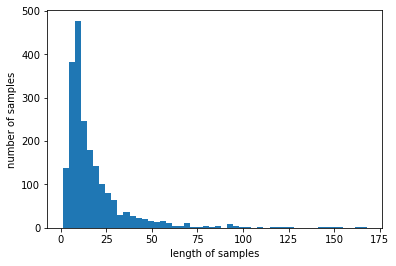

In [37]:
# sequences 길이 확인
print('리뷰의 최대 길이 :',max(len(l) for l in x_train))
print('리뷰의 평균 길이 :',sum(map(len, x_train))/len(x_train))
plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [38]:
# max_len 이하 길이의 sample이 몇 %인가?
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [39]:
max_len = 30
below_threshold_len(max_len, x_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 86.95441319107663


In [40]:
# 패딩
x_train = pad_sequences(x_train, maxlen = max_len)
#x_test = pad_sequences(x_test, maxlen = max_len)

# LSTM 학습

In [19]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [20]:
# 모델링
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [21]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [22]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=10, callbacks=[es, mc], batch_size=32, validation_split=0.4)
#history = model.fit(x_train, y_train, epochs=10, batch_size=1, validation_split=0.3)

Epoch 1/10
41/41 [==============================] - 4s 38ms/step - loss: 0.6924 - accuracy: 0.5457 - val_loss: 0.6508 - val_accuracy: 0.6512
Epoch 2/10
41/41 [==============================] - 1s 19ms/step - loss: 0.5649 - accuracy: 0.7395 - val_loss: 0.4983 - val_accuracy: 0.7671
Epoch 3/10
41/41 [==============================] - 1s 23ms/step - loss: 0.2717 - accuracy: 0.8962 - val_loss: 0.5088 - val_accuracy: 0.7856
Epoch 4/10
41/41 [==============================] - 1s 19ms/step - loss: 0.1440 - accuracy: 0.9671 - val_loss: 0.6237 - val_accuracy: 0.7810
Epoch 5/10
41/41 [==============================] - 1s 19ms/step - loss: 0.0732 - accuracy: 0.9823 - val_loss: 0.7264 - val_accuracy: 0.7717
Epoch 6/10
41/41 [==============================] - 1s 19ms/step - loss: 0.0307 - accuracy: 0.9950 - val_loss: 0.9877 - val_accuracy: 0.7694
Epoch 00006: early stopping


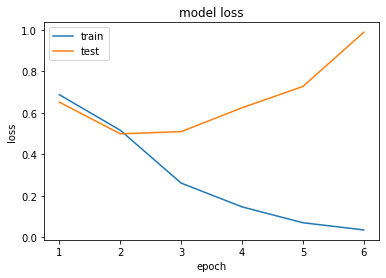

In [23]:
epochs = range(1, len(history.history['accuracy']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [24]:
loaded_model = load_model('best_model.h5')
#print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(x_test, y_test)[1]))

In [25]:
def sentiment_predict(new_sentence):
    okt = Okt()
    new_sentence = re.compile("[^ㄱ-ㅎ ㅏ-ㅣ 가-힣 ]+").sub('', new_sentence)
    new_sentence = okt.morphs(new_sentence, stem=False) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    print(pad_new)
    score = float(loaded_model.predict(pad_new)) # 예측
    if(score > 0.5):
        print("{:.2f}% 확률로 안티 댓글입니다.\n".format(score * 100))
    else:
        print("{:.2f}% 확률로 찬티 댓글입니다.\n".format((1 - score) * 100))

In [28]:
for i in sample:
    sentiment_predict(i)

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   6 268 126 401  44 216   1]]
82.25% 확률로 찬티 댓글입니다.

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   9  49   6 146 441]]
99.32% 확률로 찬티 댓글입니다.

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0  31 266 493   1   1]]
69.44% 확률로 안티 댓글입니다.

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0   92  571    1   44
  1369    1]]
76.50% 확률로 찬티 댓글입니다.

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0  163    8   37   11   99    7   80
     1 1844]]
70.81% 확률로 안티 댓글입니다.

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0   36   49   37 2238  101
  1505  437]]
70.45% 확률로 안티 댓글입니다.



In [884]:
sentiment_predict('이거 완전 개잡주')

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   4 408  16  47]]
98.73% 확률로 안티 댓글입니다.



In [27]:
sample = ['오늘 무슨 날이냐 왜이렇게 오르냐',
         '개잡주 오늘 손절했습니다',
         '이제 오를 일만 남았습니다 버티세요',
         '이유라도 알자 왜 떨어지는 거임?',
         '이번주 내로 전고점 달성하겠다',
         '쓰레기 잡주 내가 들어온 게 잘못이지']

# GRU학습

In [29]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [30]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(GRU(128))
model.add(Dense(1, activation='sigmoid'))

In [31]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [32]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=20, callbacks=[es, mc], batch_size=16, validation_split=0.4)

Epoch 1/20
81/81 [==============================] - 5s 21ms/step - loss: 0.6781 - acc: 0.5607 - val_loss: 0.5607 - val_acc: 0.7300

Epoch 00001: val_acc improved from -inf to 0.73001, saving model to best_model.h5
Epoch 2/20
81/81 [==============================] - 1s 16ms/step - loss: 0.3705 - acc: 0.8551 - val_loss: 0.5116 - val_acc: 0.7567

Epoch 00002: val_acc improved from 0.73001 to 0.75666, saving model to best_model.h5
Epoch 3/20
81/81 [==============================] - 1s 14ms/step - loss: 0.1548 - acc: 0.9530 - val_loss: 0.6799 - val_acc: 0.7694

Epoch 00003: val_acc improved from 0.75666 to 0.76941, saving model to best_model.h5
Epoch 4/20
81/81 [==============================] - 1s 13ms/step - loss: 0.0836 - acc: 0.9777 - val_loss: 0.6991 - val_acc: 0.7323

Epoch 00004: val_acc did not improve from 0.76941
Epoch 5/20
81/81 [==============================] - 1s 13ms/step - loss: 0.1052 - acc: 0.9578 - val_loss: 0.8856 - val_acc: 0.7555

Epoch 00005: val_acc did not improve f

In [33]:
loaded_model = load_model('best_model.h5')
#print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

In [34]:
def sentiment_predict(new_sentence):
    print(new_sentence)
    okt = Okt()
    new_sentence = okt.morphs(new_sentence, stem=False) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = float(loaded_model.predict(pad_new)) # 예측
    if(score > 0.5):
        print("{:.2f}% 확률로 안티입니다.\n".format(score * 100))
    else:
        print("{:.2f}% 확률로 찬티입니다.\n".format((1 - score) * 100))

In [35]:
sample = ['오늘 무슨 날이냐 왜이렇게 오르냐',
         '개잡주 오늘 손절했습니다',
         '이제 오를 일만 남았습니다 버티세요',
         '이유라도 알자 왜 떨어지는 거임?',
         '이번주 내로 전고점 달성하겠다',
         '쓰레기 잡주 내가 들어온 게 잘못이지',
         '거봐 내가 오른다고 했지 호재가 넘친다~~',
         '연기금 그만 좀 팔아라',
         '지금부터 차근차근 분할매수 하세요!',
         '빠른 손절이 답이나 뭐하냐']

In [36]:
for i in sample:
    sentiment_predict(i)

오늘 무슨 날이냐 왜이렇게 오르냐
56.50% 확률로 찬티입니다.

개잡주 오늘 손절했습니다
93.83% 확률로 안티입니다.

이제 오를 일만 남았습니다 버티세요
92.44% 확률로 찬티입니다.

이유라도 알자 왜 떨어지는 거임?
97.37% 확률로 안티입니다.

이번주 내로 전고점 달성하겠다
97.24% 확률로 안티입니다.

쓰레기 잡주 내가 들어온 게 잘못이지
71.63% 확률로 찬티입니다.

거봐 내가 오른다고 했지 호재가 넘친다~~
99.86% 확률로 찬티입니다.

연기금 그만 좀 팔아라
99.50% 확률로 안티입니다.

지금부터 차근차근 분할매수 하세요!
99.20% 확률로 찬티입니다.

빠른 손절이 답이나 뭐하냐
96.79% 확률로 안티입니다.



In [897]:
# 가중치 새로 넣어서
loaded_model = load_model('Weight/35.h5')
for i in sample:
    sentiment_predict(i)

오늘 무슨 날이냐 왜이렇게 오르냐
94.57% 확률로 긍정 리뷰입니다.

개잡주 오늘 손절했습니다
81.64% 확률로 부정 리뷰입니다.

이제 오를 일만 남았습니다 버티세요
98.30% 확률로 긍정 리뷰입니다.

이유라도 알자 왜 떨어지는 거임?
87.42% 확률로 긍정 리뷰입니다.

이번주 내로 전고점 달성하겠다
61.57% 확률로 긍정 리뷰입니다.

쓰레기 잡주 내가 들어온 게 잘못이지
99.47% 확률로 부정 리뷰입니다.

거봐 내가 오른다고 했지 호재가 넘친다~~
97.51% 확률로 긍정 리뷰입니다.

연기금 그만 좀 팔아라
61.07% 확률로 부정 리뷰입니다.

지금부터 차근차근 분할매수 하세요!
98.35% 확률로 긍정 리뷰입니다.

빠른 손절이 답이나 뭐하냐
99.89% 확률로 부정 리뷰입니다.



In [901]:
sentiment_predict('')

이제 오를일만 남았다. 참 오래도록 바닥 다졌지...
79.99% 확률로 긍정 리뷰입니다.

